# Script to read and process netCDF data

## Import libraries

In [1]:
import rasterio
from rasterio.features import geometry_mask
import geopandas as gpd
import xarray as xr
import rioxarray
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import math
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.ticker import FuncFormatter, FixedLocator

## Import shapefile and netCDF data

In [2]:
# Enable Dask's automatic parallelization
dask.config.set(scheduler='threads')

<Axes: >

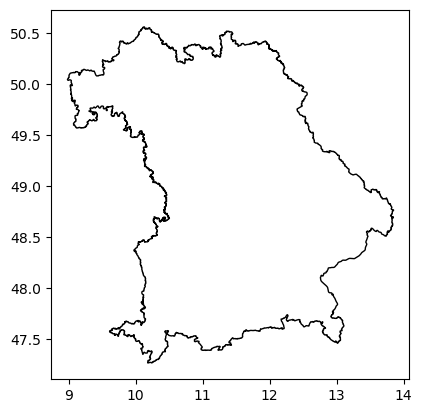

In [3]:
# Load the shapefile
shapefile_path = r"C:\Users\project\bavaria_outline.shp"
bavaria_polygon = gpd.read_file(shapefile_path)
bavaria_polygon = bavaria_polygon.to_crs('EPSG:4326')

# check the shapefile
bavaria_polygon.plot(color='white', edgecolor='black')

In [4]:
# Open the netCDF file

data = xr.open_dataset('landcover_average.nc').chunk({'variable': 10, 'lat': 1000, 'lon': 1000})

In [5]:
data['lc_avg']

<xarray.DataArray 'lc_avg' (variable: 12, lat: 13920, lon: 39000)> Size: 26GB
dask.array<xarray-lc_avg, shape=(12, 13920, 39000), dtype=float32, chunksize=(10, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 111kB -56.0 -55.99 -55.98 -55.97 ... 59.98 59.99 60.0
  * lon      (lon) float64 312kB -145.0 -145.0 -145.0 ... 180.0 180.0 180.0
Dimensions without coordinates: variable
Attributes:
    valid_range:              [  0 255]
    COLOR_TABLE_RULE_RGB_0:   0.000000e+00 2.000000e+01 255 255 0 0 255 0
    COLOR_TABLE_RULE_RGB_1:   2.000000e+01 4.000000e+01 0 255 0 0 255 255
    COLOR_TABLE_RULE_RGB_2:   4.000000e+01 6.000000e+01 0 255 255 0 0 255
    COLOR_TABLE_RULE_RGB_3:   6.000000e+01 8.000000e+01 0 0 255 255 0 255
    COLOR_TABLE_RULE_RGB_4:   8.000000e+01 1.000000e+02 255 0 255 255 0 0
    COLOR_TABLE_RULES_COUNT:  5
    Generated_with:           GRASS GIS 7.0.0beta1
    grid_mapping:             crs
    long_name:                Average_upstream_landcover
    units:                    Percent cover [%]

## Clip the netCDF data

In [6]:
# Convert the dataset to use rioxarray for geospatial operations, setting the CRS
data_rio = data.rio.write_crs("EPSG:4326")

In [7]:
# Crop the data using the region of interest, applying the shapefile's geometry
clipped_data = data_rio.rio.clip(bavaria_polygon.geometry.apply(mapping), bavaria_polygon.crs, drop=True)

In [8]:
clipped_data

<xarray.Dataset> Size: 11MB
Dimensions:  (lat: 396, lon: 584, variable: 12)
Coordinates:
  * lat      (lat) float64 3kB 47.27 47.28 47.29 47.3 ... 50.55 50.55 50.56
  * lon      (lon) float64 5kB 8.979 8.988 8.996 9.004 ... 13.82 13.83 13.84
    crs      int32 4B 0
Dimensions without coordinates: variable
Data variables:
    lc_avg   (variable, lat, lon) float32 11MB dask.array<chunksize=(10, 396, 523), meta=np.ndarray>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 1.10.0, released 2013/04/24
    units:               Percent cover [%]
    Source:              Consensus landcover dataset, Tuanmu & Jetz (2014)
    Dataset:             Upstream average landcover
    scale_factor:        1
    Author:              sami.domisch@yale.edu & giuseppe.amatulli@gmail.com
    Software:            GRASS 7 using the add-ons r.stream.watersheds & r.st...

## Plot the data

## Convert xarray to dataframes

In [10]:
# Flatten the data to check the dimensions required for the dataframe

flat_data = clipped_data['lc_avg'].stack(space=['lat', 'lon'])
flat_data

<xarray.DataArray 'lc_avg' (variable: 12, space: 231264)> Size: 11MB
dask.array<reshape, shape=(12, 231264), dtype=float32, chunksize=(10, 115632), chunktype=numpy.ndarray>
Coordinates:
    crs      int32 4B 0
  * space    (space) object 2MB MultiIndex
  * lat      (space) float64 2MB 47.27 47.27 47.27 47.27 ... 50.56 50.56 50.56
  * lon      (space) float64 2MB 8.979 8.988 8.996 9.004 ... 13.82 13.83 13.84
Dimensions without coordinates: variable
Attributes:
    valid_range:              [  0 255]
    COLOR_TABLE_RULE_RGB_0:   0.000000e+00 2.000000e+01 255 255 0 0 255 0
    COLOR_TABLE_RULE_RGB_1:   2.000000e+01 4.000000e+01 0 255 0 0 255 255
    COLOR_TABLE_RULE_RGB_2:   4.000000e+01 6.000000e+01 0 255 255 0 0 255
    COLOR_TABLE_RULE_RGB_3:   6.000000e+01 8.000000e+01 0 0 255 255 0 255
    COLOR_TABLE_RULE_RGB_4:   8.000000e+01 1.000000e+02 255 0 255 255 0 0
    COLOR_TABLE_RULES_COUNT:  5
    Generated_with:           GRASS GIS 7.0.0beta1
    grid_mapping:             crs
    long_name:                Average_upstream_landcover
    units:                    Percent cover [%]

In [11]:
# Prepare the dataframes

# Extract variable
lc_avg = clipped_data['lc_avg']

# Convert the DataArray to a pandas DataFrame
df = lc_avg.to_dataframe(name='value').reset_index()
display(df)


#pd.options.display.max_rows = 1000
#pd.options.display.min_rows = 500

# Pivot the DataFrame to have bands as columns
df_pivoted = df.pivot(index=['lat', 'lon'], columns='variable', values='value').reset_index()
display(df_pivoted)

#remove nan values
df_filtered = df_pivoted.dropna(axis=0, how='any').reset_index()

display(df_filtered)


,variable,lat,lon,crs,value
0,0,47.270833,8.979167,0,NaN
1,0,47.270833,8.987500,0,NaN
2,0,47.270833,8.995833,0,NaN
3,0,47.270833,9.004167,0,NaN
4,0,47.270833,9.012500,0,NaN
...,...,...,...,...,...
2775163,11,50.562500,13.804167,0,NaN
2775164,11,50.562500,13.812500,0,NaN
2775165,11,50.562500,13.820833,0,NaN
2775166,11,50.562500,13.829167,0,NaN


variable,lat,lon,0,1,2,3,4,5,6,7,8,9,10,11
0,47.270833,8.979167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,47.270833,8.987500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,47.270833,8.995833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,47.270833,9.004167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,47.270833,9.012500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231259,50.562500,13.804167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231260,50.562500,13.812500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231261,50.562500,13.820833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231262,50.562500,13.829167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


variable,index,lat,lon,0,1,2,3,4,5,6,7,8,9,10,11
0,1902,47.295833,10.229167,29.0,0.0,6.0,7.0,3.0,25.0,20.0,0.0,0.0,0.0,8.0,2.0
1,2487,47.304167,10.237500,28.0,0.0,6.0,6.0,3.0,25.0,21.0,0.0,0.0,0.0,8.0,2.0
2,2488,47.304167,10.245833,28.0,0.0,8.0,8.0,4.0,23.0,20.0,0.0,0.0,0.0,7.0,2.0
3,3073,47.312500,10.254167,27.0,0.0,7.0,9.0,4.0,24.0,21.0,0.0,0.0,0.0,7.0,2.0
4,3074,47.312500,10.262500,25.0,0.0,7.0,10.0,5.0,23.0,18.0,0.0,0.0,0.0,10.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16445,228480,50.529167,10.112500,0.0,0.0,7.0,10.0,0.0,10.0,66.0,0.0,0.0,0.0,7.0,0.0
16446,228481,50.529167,10.120833,0.0,0.0,7.0,9.0,0.0,10.0,66.0,0.0,0.0,0.0,9.0,0.0
16447,228482,50.529167,10.129167,0.0,0.0,6.0,8.0,0.0,9.0,66.0,0.0,0.0,0.0,11.0,0.0
16448,228484,50.529167,10.145833,0.0,0.0,10.0,17.0,0.0,5.0,55.0,0.0,0.0,0.0,12.0,0.0


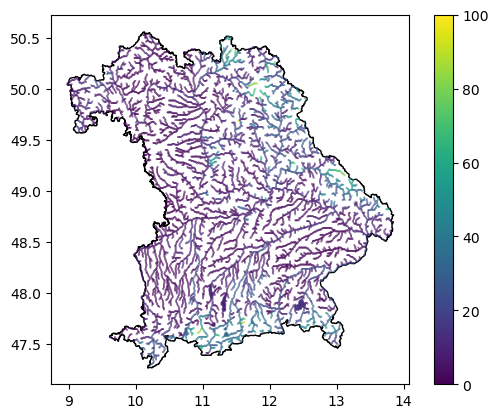

In [12]:
# Plotting again to check if the dataframe is correct

bavaria_polygon.plot(color='white', edgecolor='black')
plt.scatter(df_filtered['lon'], df_filtered['lat'], c=df_filtered.iloc[:,3], cmap= 'viridis', s= 0.05 )
plt.colorbar()

In [13]:
df = df_filtered.drop(columns = ['index', 'lat', 'lon'])
lc_dat = df.to_numpy()
lc_all = lc_dat.flatten()
lc_dat

array([[29.,  0.,  6., ...,  0.,  8.,  2.],
       [28.,  0.,  6., ...,  0.,  8.,  2.],
       [28.,  0.,  8., ...,  0.,  7.,  2.],
       ...,
       [ 0.,  0.,  6., ...,  0., 11.,  0.],
       [ 0.,  0., 10., ...,  0., 12.,  0.],
       [ 0.,  0., 11., ...,  0., 10.,  0.]], dtype=float32)

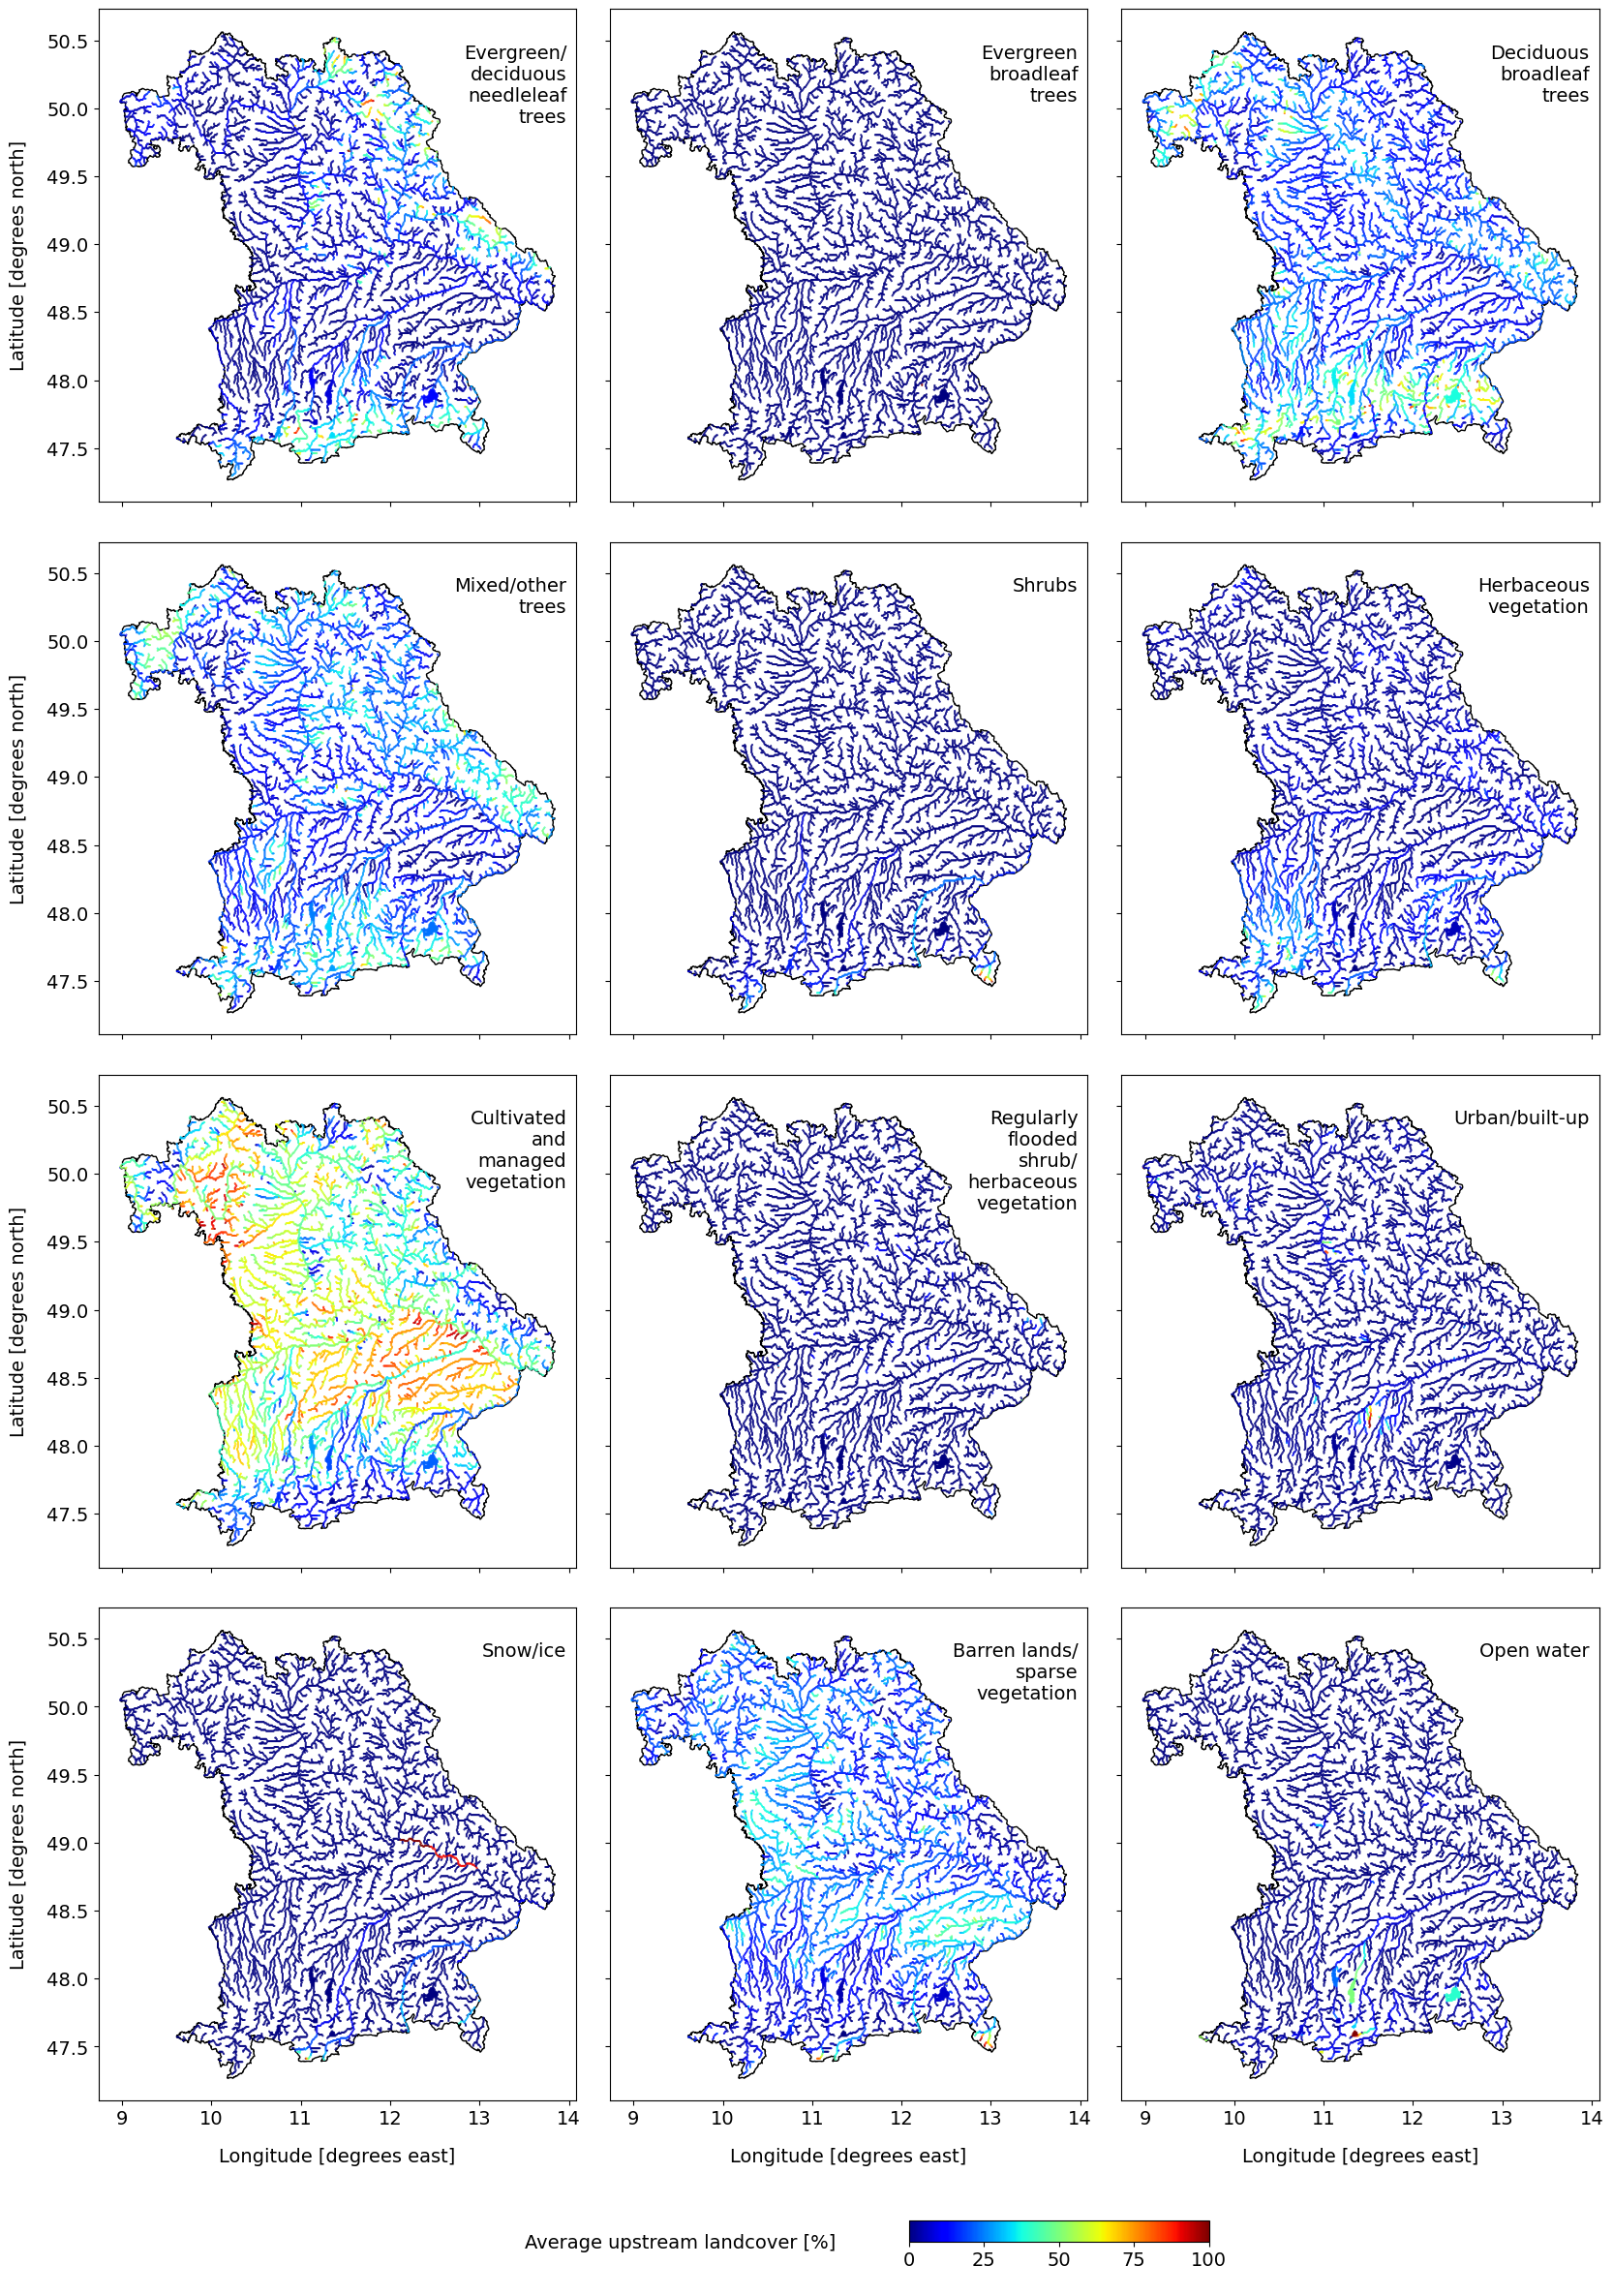

In [15]:
# Create subplots for all the months


row_dict = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 4, 13: 4, 14: 4}  # storing row indices for subplot in a dictionary
col_dict = {0: 0, 1: 1, 2: 2, 3: 0, 4: 1, 5: 2, 6: 0, 7: 1, 8: 2, 9: 0, 10: 1, 11: 2, 12: 0, 13: 1, 14: 2}  # storing column indices for subplot in a dictionary
bands_dict = {0:'Evergreen/\ndeciduous\nneedleleaf\ntrees', 1:'Evergreen\nbroadleaf\ntrees', 2:'Deciduous\nbroadleaf\ntrees', 3:'Mixed/other\ntrees', 
              4:'Shrubs', 5:'Herbaceous\nvegetation', 6:'Cultivated\nand\nmanaged\nvegetation', 7:'Regularly\nflooded\nshrub/\nherbaceous\nvegetation', 
              8:'Urban/built-up', 9:'Snow/ice', 10:'Barren lands/\nsparse\nvegetation', 11:'Open water'}


norm = plt.Normalize(vmin=lc_all.min(), vmax=lc_all.max())
fig = plt.figure(figsize=(20, 30))
grid = plt.GridSpec(5, 3, wspace = 0.07,hspace = 0.01, height_ratios=[10,10,10,10,2])

for i in range(13):
# If i is less than 12, then we plot the subplots for available data. If i is 12, we plot the last row of subplot grid and combine all 3 of its columns into a single row. 
# The colorbar and the size legend is then plotted in this last subplot and the borders are then removed.            
    if i < 12:    

        ax = fig.add_subplot(grid[row_dict[i], col_dict[i]])
        bavaria_polygon.plot(ax=ax, color='white', edgecolor='black')
        sc = ax.scatter(df_filtered.iloc[:,2], df_filtered.iloc[:,1], c=norm(df_filtered.iloc[:,i+3]), cmap='jet', s=0.2)
        
        ax.text(0.98, 0.93, bands_dict[i], transform = ax.transAxes, size = 14,ha='right',va='top')
        
        # only add x label for the last row of subplot (last row of the subplots with data. the actual last row is the one with color bar)
        if i in range(9,12):
            
            ax.set_xlabel('Longitude [degrees east]', fontsize = 14, labelpad = 14)

        
        # only add y label for the first column of subplot    
        if i in range(0,10,3):
            
            ax.set_ylabel('Latitude [degrees north]', fontsize = 14, labelpad = 14)

            
        if i not in range(9,12):
            ax.set_xticklabels([])
        
        
        if i not in range(0,10,3): 
            ax.set_yticklabels([])

        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
    
    else:
        # plot the legend in the last row of subplot and combine all the columns
        cbar_ax = fig.add_subplot(grid[row_dict[i], :])
        
# manually adjust the positions of the subplots and the color bar
for ax in fig.axes[:-1]:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 0.02, pos.width, pos.height])      

# insert the colorbar as an axes in the last row of subplot grid. this row was reserved for legend and has no data. 
cax = cbar_ax.inset_axes([0.54, 0.42,0.2, 0.2], transform=cbar_ax.transAxes) # [left, bottom, width, height] 
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), cax=cax, orientation='horizontal')
min_cbar = lc_all.min()
max_cbar = lc_all.max()
ticks = np.linspace(lc_all.min(),lc_all.max() , 5).astype(int)
cbar.set_ticks(ticks) # the colorbar represents the normalized data by default so add ticks manually
cbar.set_ticklabels(np.linspace(min_cbar,max_cbar , 5).astype(int), fontsize=14 )
cbar_ax.text(0.39, 0.36, "Average upstream landcover [%] ", fontsize=14, ha="center", transform=cbar_ax.transAxes)

# remove boundaries of the last row of subplot grid
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)

# Apply tight layout to subplots only
plt.savefig('stations_landcover_average_400dpi.jpg', format = 'jpg', bbox_inches = 'tight', dpi=400)

In [13]:
# # save the filtered dataframe
# filepath = "df_filtered_landcover"
# with open(filepath, 'wb') as file:
#     pickle.dump(df_filtered, file)